In [1]:
import numpy as np
from numpy.linalg import pinv,inv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy import linalg
from sklearn.linear_model import LogisticRegression
from sklearn.utils.extmath import svd_flip
from sklearn.decomposition import PCA

from tqdm import tqdm
import pickle

from transformers import AutoModelForTokenClassification

In [2]:
with open('embeddings.pickle', 'rb') as handle:
    eval_dict = pickle.load(handle)

In [3]:
TRAIN_LANGS = ["en", "zh", "es", "de", "nl"]

lang_color = {
    'en': 'r',
    'zh': 'b',
    'es': 'g',
    'de': 'yellow',
    'nl': 'orange'
}

label_color = {
    'B-LOC': 'r',
    'B-MISC': 'g',
    'B-ORG': 'b',
    'B-PER': 'yellow',
    'I-LOC': 'r',
    'I-MISC': 'g',
    'I-ORG': 'b',
    'I-PER': 'yellow',
    'O': 'orange'
}

label_color_small = {
    'LOC': 'r',
    'MISC': 'g',
    'ORG': 'b',
    'PER': 'yellow',
    'O': 'orange'
}

In [4]:
embeddings_arr = []
words_arr = []
refs_arr = []

# merge all languages data
for lang in tqdm(TRAIN_LANGS):
    embeddings_arr.extend(eval_dict[lang]['embeddings'])
    words_arr.extend(eval_dict[lang]['words'])
    refs_arr.extend(eval_dict[lang]['refs'])

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 178.43it/s]


In [5]:
get_lang_color = lambda i: lang_color[i]
get_label_color = lambda i: label_color[i]

color_lang_arr = []
color_label_arr = []
lang_starting_index = {}

for lang in TRAIN_LANGS:
    print(f"{lang} starts from {len(color_lang_arr)}")
    lang_starting_index[lang] = len(color_lang_arr)
    
    color_lang_arr.extend(list(map(get_lang_color, eval_dict[lang]['langs'])))
    
    
color_label_arr.extend(list(map(get_label_color, refs_arr)))      

en starts from 0
zh starts from 46364
es starts from 202376
de starts from 253577
nl starts from 305273


In [6]:
color_lang_arr = np.array(color_lang_arr)  
color_label_arr = np.array(color_label_arr)  
words_arr = np.array(words_arr)
refs_arr = np.array(refs_arr)

# PCA

In [7]:
x = np.array(embeddings_arr).T
x.shape

(768, 373509)

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, svd_solver='full')
x_pca = pca.fit_transform(x.T[:]).T
pca.explained_variance_ratio_

array([0.45092514, 0.08316438, 0.070965  ])

<IPython.core.display.Javascript object>


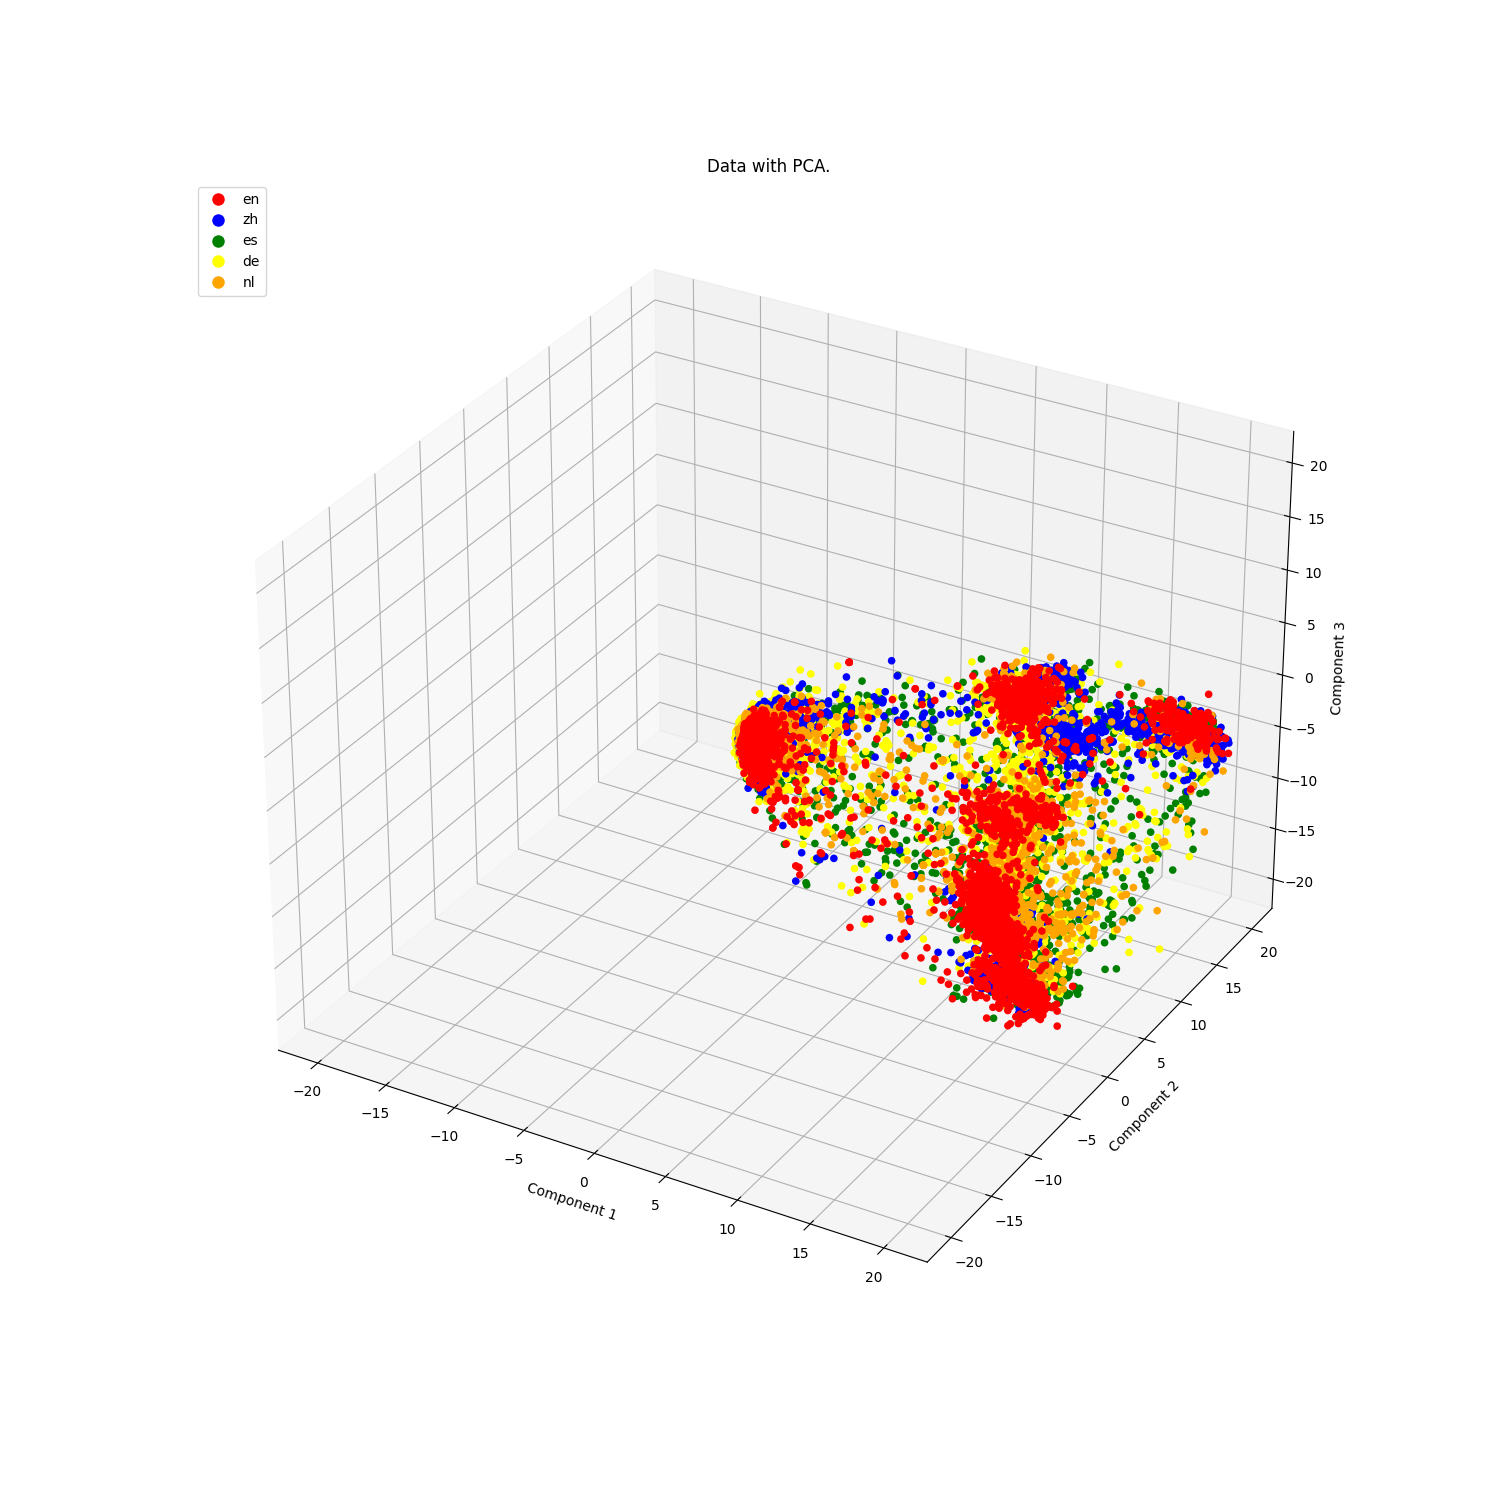

range(0, 10000)
range(46364, 56364)
range(202376, 212376)
range(253577, 263577)
range(305273, 315273)


In [19]:
%matplotlib notebook

plt.rcParams["figure.figsize"] = (15,15)
ax = plt.axes(projection='3d')
ax.grid()

# data size from each lang
size = 10000
alpha = 1

# create a scatter plot of the projection
for lang in TRAIN_LANGS:
    range_indx = range(lang_starting_index[lang], lang_starting_index[lang] + size)
    print(range_indx)
    
    #points
    ax.scatter(x_pca.T[range_indx, 0], x_pca.T[range_indx, 1], x_pca.T[range_indx, 2], color=color_lang_arr[list(range_indx)].tolist(), alpha=alpha)

    #words
#     for i, word in enumerate(words_arr[list(range_indx)].tolist()):
#         ax.text(x_pca.T[range_indx[i], 0], x_pca.T[range_indx[i], 1], x_pca.T[range_indx[i], 2], word)
         

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=l, markerfacecolor=c, markersize=10) 
    for l, c in lang_color.items()
]

# Create the figure
ax.legend(handles=legend_elements, loc='upper left')
ax.set_xlim(-22, 22)
ax.set_ylim(-22, 22)
ax.set_zlim(-22, 22)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.set_title('Data with PCA.')
        
plt.show()

# PCA: Step by step

In [20]:
# center data
x_mean = np.mean(x.T, axis=0)
x_center = (x.T - x_mean).T
x_mean.shape, x_center.shape

((768,), (768, 373509))

$$
\begin{pmatrix} 1 & 0 & 0 & t_x \\ 0 & 1 & 0 & t_y  \\ 0 & 0 & 1 & t_z \\ 0 & 0 & 0 & 1\end{pmatrix} 
\begin{pmatrix} x_{1} \\ x_{2} \\ x_{3} \\ 1 \end{pmatrix}
=
\begin{pmatrix} 1 & 0 & 0 & x_{1} + t_x  \\ 0 & 1 & 0 & x_{2} + t_y \\ 0 & 0 & 1 & x_{3} + t_z \\ 0 & 0 & 0 & 1\end{pmatrix} 
$$

In [21]:
# the centering matrix
M = np.eye(x_mean.shape[0] + 1)
M[:, -1] = np.append(-x_mean, [1])
M.shape

(769, 769)

In [22]:
# (769,373509) = (768,373509) + (1,373509)
# augment data matrix
x_augumented = np.vstack((x, x.shape[1]*[1]))
x_augumented.shape

(769, 373509)

In [23]:
# (769,373509) = (769,769) X (769,373509)
x_center_with_transform_matrix= np.dot(M, x_augumented)

# get unaugmented part
x_center_with_transform_matrix = x_center_with_transform_matrix[:-1]
x_center_with_transform_matrix

array([[-0.02227974, -0.06794292,  1.08130398, ..., -0.06138176,
        -0.05539834,  0.26947969],
       [ 0.02174807, -0.12933087,  1.01392524, ..., -0.13974762,
        -0.00332975, -0.16792166],
       [ 0.24780107,  0.34350097, -0.88790601, ...,  0.20618606,
         0.1354059 ,  0.11744201],
       ...,
       [ 0.32197356,  0.23552954, -1.71840569, ..., -0.01649296,
         0.2022593 ,  0.17890191],
       [-0.26352292, -0.18016165,  0.84740039, ..., -0.23661453,
         0.01792371, -0.0277127 ],
       [-0.15088898, -0.12253022,  0.30163264, ..., -0.02718562,
        -0.16415608,  0.03245801]])

In [24]:
# IMPORTANT!!!!! check M matrix validity
np.allclose(x_center, x_center_with_transform_matrix)

True

## Step 2. Center boundary line with the centering matrix

 
$$
\text{New boundary coeffs = }
\begin{pmatrix} w_1 & w_2 & w_3 & 1 \end{pmatrix} 
\begin{pmatrix}
    1 & 0 & 0 & t_x \\ 
    0 & 1 & 0 & t_y \\
    0 & 0 & 1 & t_z \\
    0 & 0 & 0 & 1
\end{pmatrix}^{-1}
$$

In [25]:
# Classifier
path = '/mnt/xtb/knarik/outputs/DG/lang_classifiers/domain_en_de_zh_epoch_50_en_de_zh_epoch_10'

classifier = AutoModelForTokenClassification.from_pretrained(path, output_hidden_states=True, num_labels=3)  

# 3 classifiers
clf_en_w, clf_de_w, clf_zh_w = classifier.classifier.weight.detach().numpy()
clf_en_b, clf_de_b, clf_zh_b = classifier.classifier.bias.detach().numpy()

In [26]:
clf_en_w.shape, clf_en_b

((768,), 0.052104965)

In [27]:
# augment line without the intercept
# M(m,n) matrix has left inverse iif m > n.

clf_en_w_centered = np.dot(np.append(clf_en_w, 1), pinv(M)) 
clf_zh_w_centered = np.dot(np.append(clf_zh_w, 1), pinv(M)) 
clf_de_w_centered = np.dot(np.append(clf_de_w, 1), pinv(M)) 

clf_en_w_centered.shape

(769,)

## Step 3: Find PCA transformation matrix

$$
P X = Y \\[1ex]
P X X^{-1} = Y X^{-1} \\[1ex]
P = Y X^{-1}
$$

In [28]:
# (3, 3) = (3, 373509) X (373509, 3)
# X(m,n) matrix has right inverse iif n > m.
# alternativly, just P=pca.components_
P = np.dot(x_pca, pinv(x_center))
P.shape

(3, 768)

In [29]:
x_pca_with_matrix_transform = P.dot(x_center)

In [30]:
# IMPORTANT!!!!! check P matrix validity
np.allclose(x_pca, x_pca_with_matrix_transform)

False

## Step 4: Transform boundary line with the PCA matrix

 
$$
\text{New boundary coeffs = }
\begin{bmatrix} w_1 & w_2 & w_3\end{bmatrix} 
P^{-1}
$$

In [35]:
# new coeffs for boundary line

#(1,2) = (1, 3) X (3,2)
# clf_en_w_centered, last dim is the augmented data dim
new_coeffs_en = np.dot(clf_en_w_centered[:-1], pinv(P))
new_coeffs_zh = np.dot(clf_zh_w_centered[:-1], pinv(P))
new_coeffs_de = np.dot(clf_de_w_centered[:-1], pinv(P))
new_coeffs_en

array([ 0.02641758, -0.0877829 , -0.09038828])

# Plots

<IPython.core.display.Javascript object>


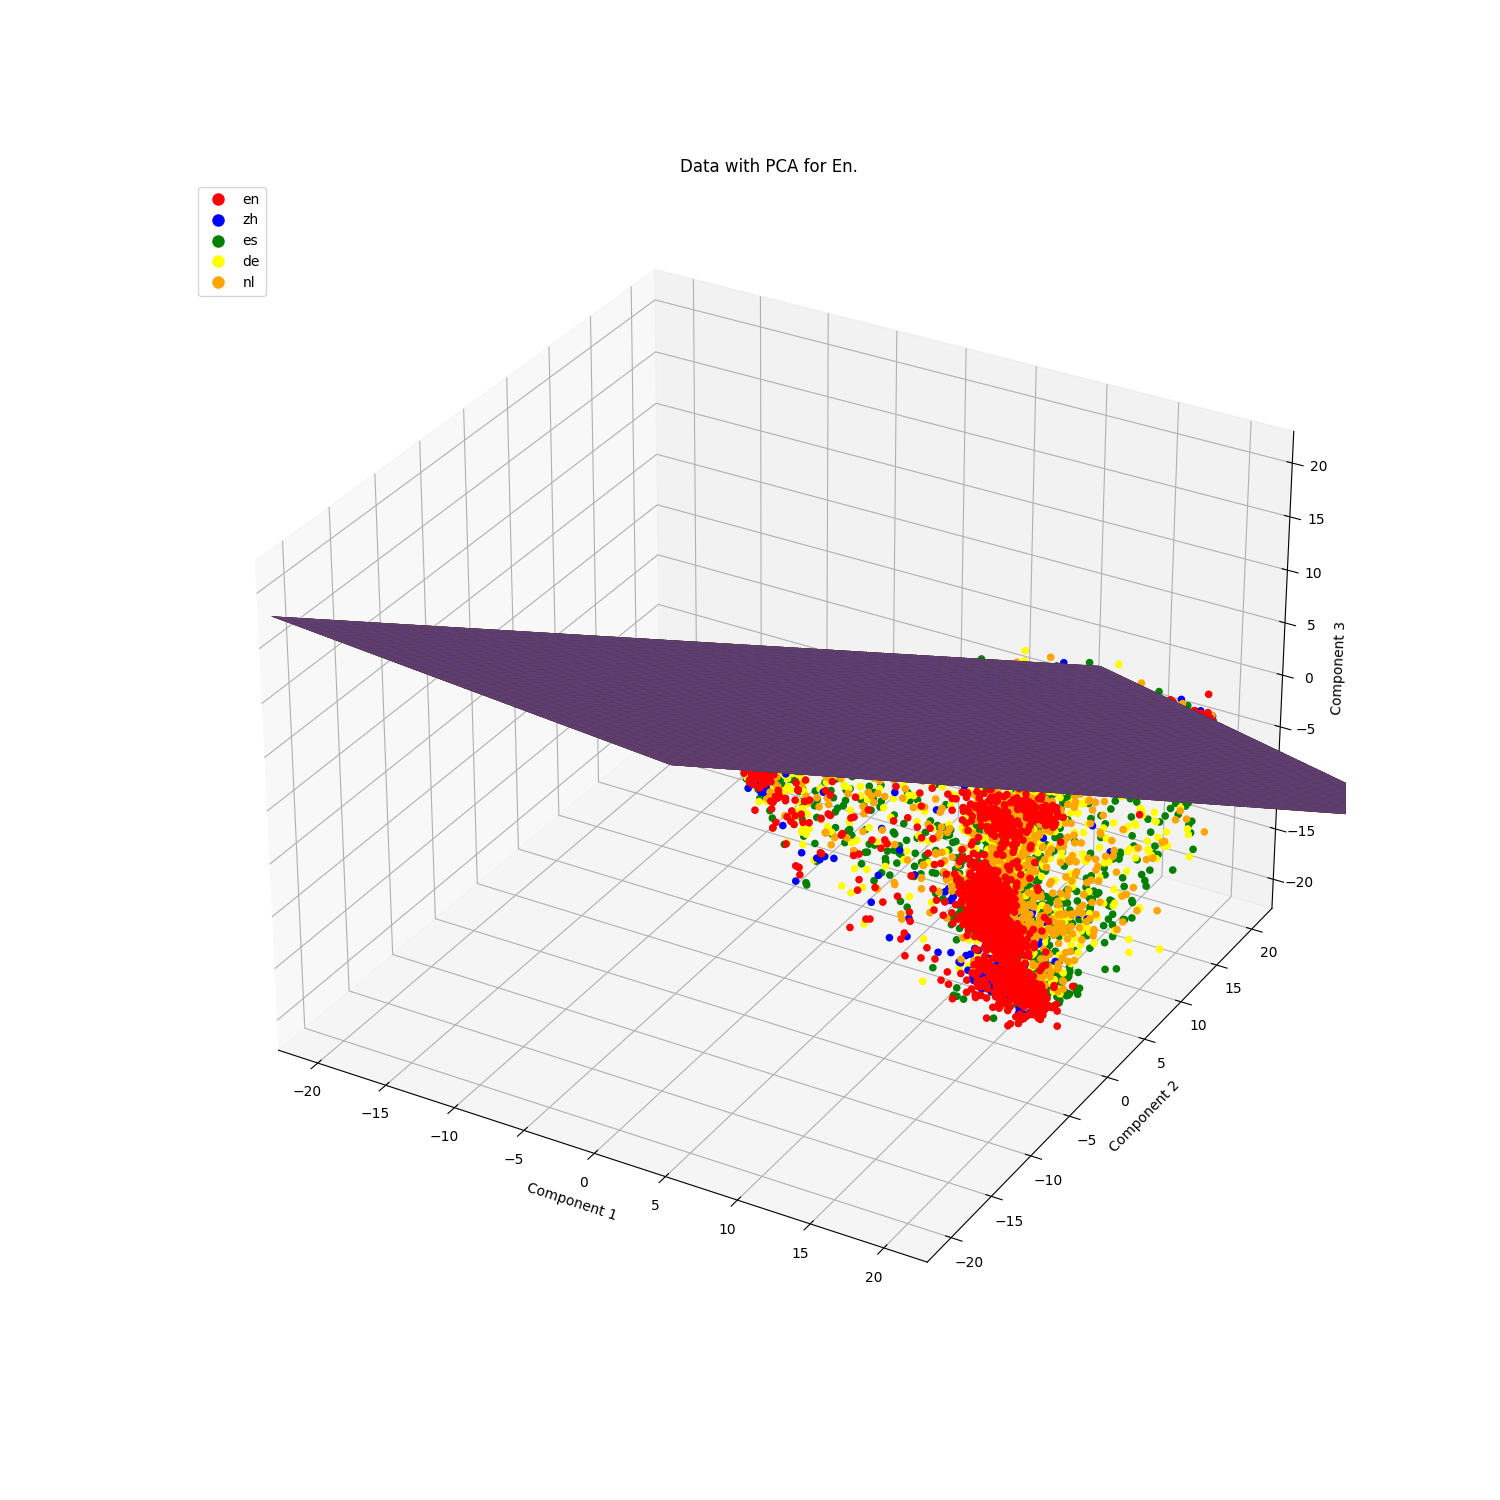

range(0, 10000)
range(46364, 56364)
range(202376, 212376)
range(253577, 263577)
range(305273, 315273)


In [36]:
%matplotlib notebook

plt.rcParams["figure.figsize"] = (15,15)
ax = plt.axes(projection='3d')
ax.grid()

# data size from each lang
size = 10000
alpha = 1

# create a scatter plot of the projection
for lang in TRAIN_LANGS:
    range_indx = range(lang_starting_index[lang], lang_starting_index[lang] + size)
    print(range_indx)
    
    #points
    ax.scatter(x_pca.T[range_indx, 0], x_pca.T[range_indx, 1], x_pca.T[range_indx, 2], color=color_lang_arr[list(range_indx)].tolist(), alpha=alpha)

    
    #boundary    
    x1_size = np.max([np.abs(np.min(x_pca[0])), np.abs(np.max(x_pca[0]))])
    x2_size = np.max([np.abs(np.min(x_pca[1])), np.abs(np.max(x_pca[1]))])
    
    boundary_x1_pca = np.linspace([-x1_size, x1_size], 30)
    boundary_x2_pca = np.linspace([-x2_size, x2_size], 30)
    xx, yy = np.meshgrid(boundary_x1_pca, boundary_x2_pca)
    
    
    # IMPORTANT!!!!! put old intercept 
    zz_en = -(clf_en_b + clf_en_w_centered[-1] + np.dot(new_coeffs_en[0], xx) + np.dot(new_coeffs_en[1], yy)) / new_coeffs_en[2] 
    ax.plot_surface(xx, yy, zz_en)
    
    
    #words
#     for i, word in enumerate(words_arr[list(range_indx)].tolist()):
#         ax.text(x_pca.T[range_indx[i], 0], x_pca.T[range_indx[i], 1], x_pca.T[range_indx[i], 2], word)
         

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=l, markerfacecolor=c, markersize=10) 
    for l, c in lang_color.items()
]

# Create the figure
ax.legend(handles=legend_elements, loc='upper left')
ax.set_xlim(-22, 22)
ax.set_ylim(-22, 22)
ax.set_zlim(-22, 22)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.set_title('Data with PCA for En.')
        
plt.show()

<IPython.core.display.Javascript object>


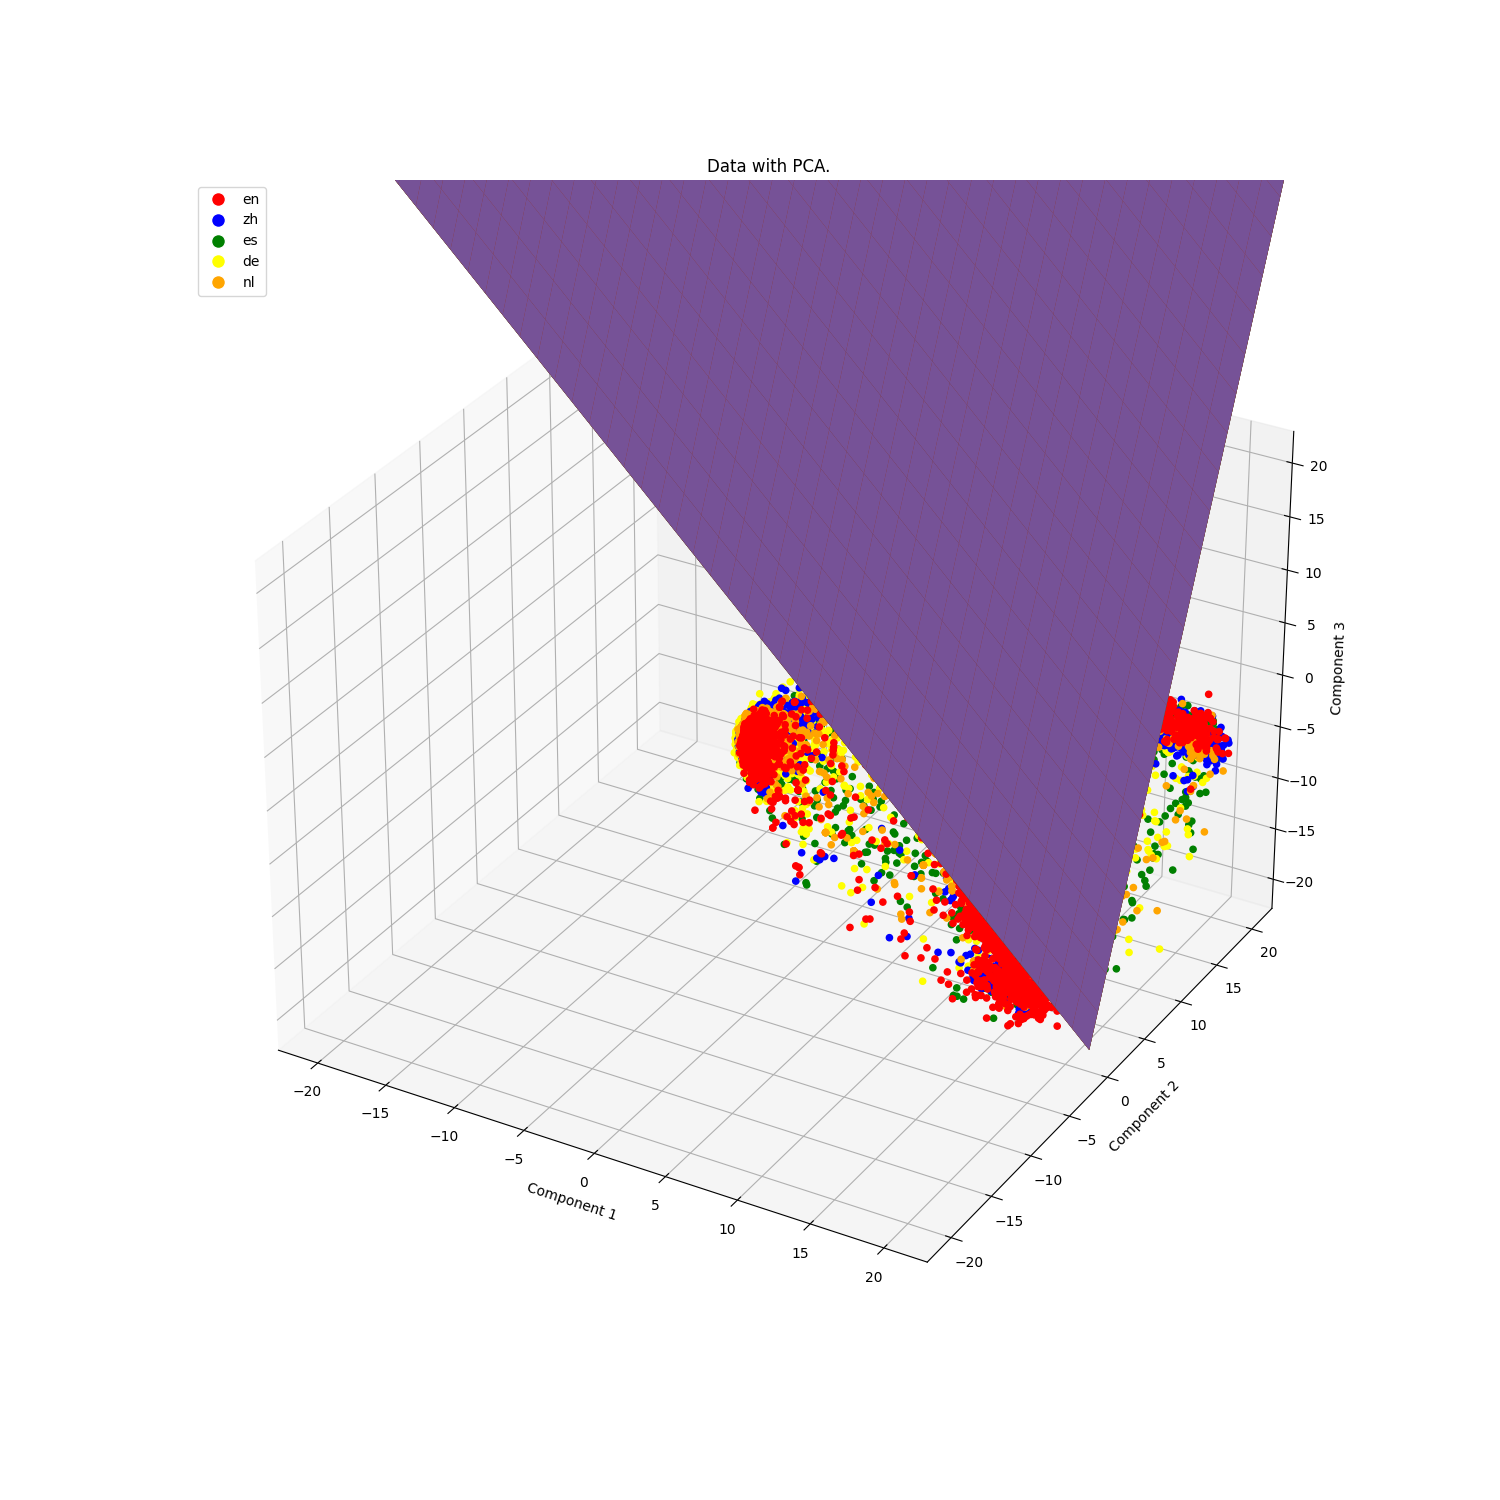

range(0, 10000)
range(46364, 56364)
range(202376, 212376)
range(253577, 263577)
range(305273, 315273)


In [37]:
%matplotlib notebook

plt.rcParams["figure.figsize"] = (15,15)
ax = plt.axes(projection='3d')
ax.grid()

# data size from each lang
size = 10000
alpha = 1

# create a scatter plot of the projection
for lang in TRAIN_LANGS:
    range_indx = range(lang_starting_index[lang], lang_starting_index[lang] + size)
    print(range_indx)
    
    #points
    ax.scatter(x_pca.T[range_indx, 0], x_pca.T[range_indx, 1], x_pca.T[range_indx, 2], color=color_lang_arr[list(range_indx)].tolist(), alpha=alpha)

    
    #boundary    
    boundary_x1_pca = np.linspace([-x1_size, x1_size], 30)
    boundary_x2_pca = np.linspace([-x2_size, x2_size], 30)
    xx, yy = np.meshgrid(boundary_x1_pca, boundary_x2_pca)
    
    
    # IMPORTANT!!!!! put old intercept 
    zz_zh = -(clf_zh_b + clf_zh_w_centered[-1] + np.dot(new_coeffs_zh[0], xx) + np.dot(new_coeffs_zh[1], yy)) / new_coeffs_zh[2] 
    ax.plot_surface(xx, yy, zz_zh)

    
    #words
#     for i, word in enumerate(words_arr[list(range_indx)].tolist()):
#         ax.text(x_pca.T[range_indx[i], 0], x_pca.T[range_indx[i], 1], x_pca.T[range_indx[i], 2], word)
         

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=l, markerfacecolor=c, markersize=10) 
    for l, c in lang_color.items()
]

# Create the figure
ax.legend(handles=legend_elements, loc='upper left')
ax.set_xlim(-22, 22)
ax.set_ylim(-22, 22)
ax.set_zlim(-22, 22)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.set_title('Data with PCA.')
        
plt.show()

<IPython.core.display.Javascript object>


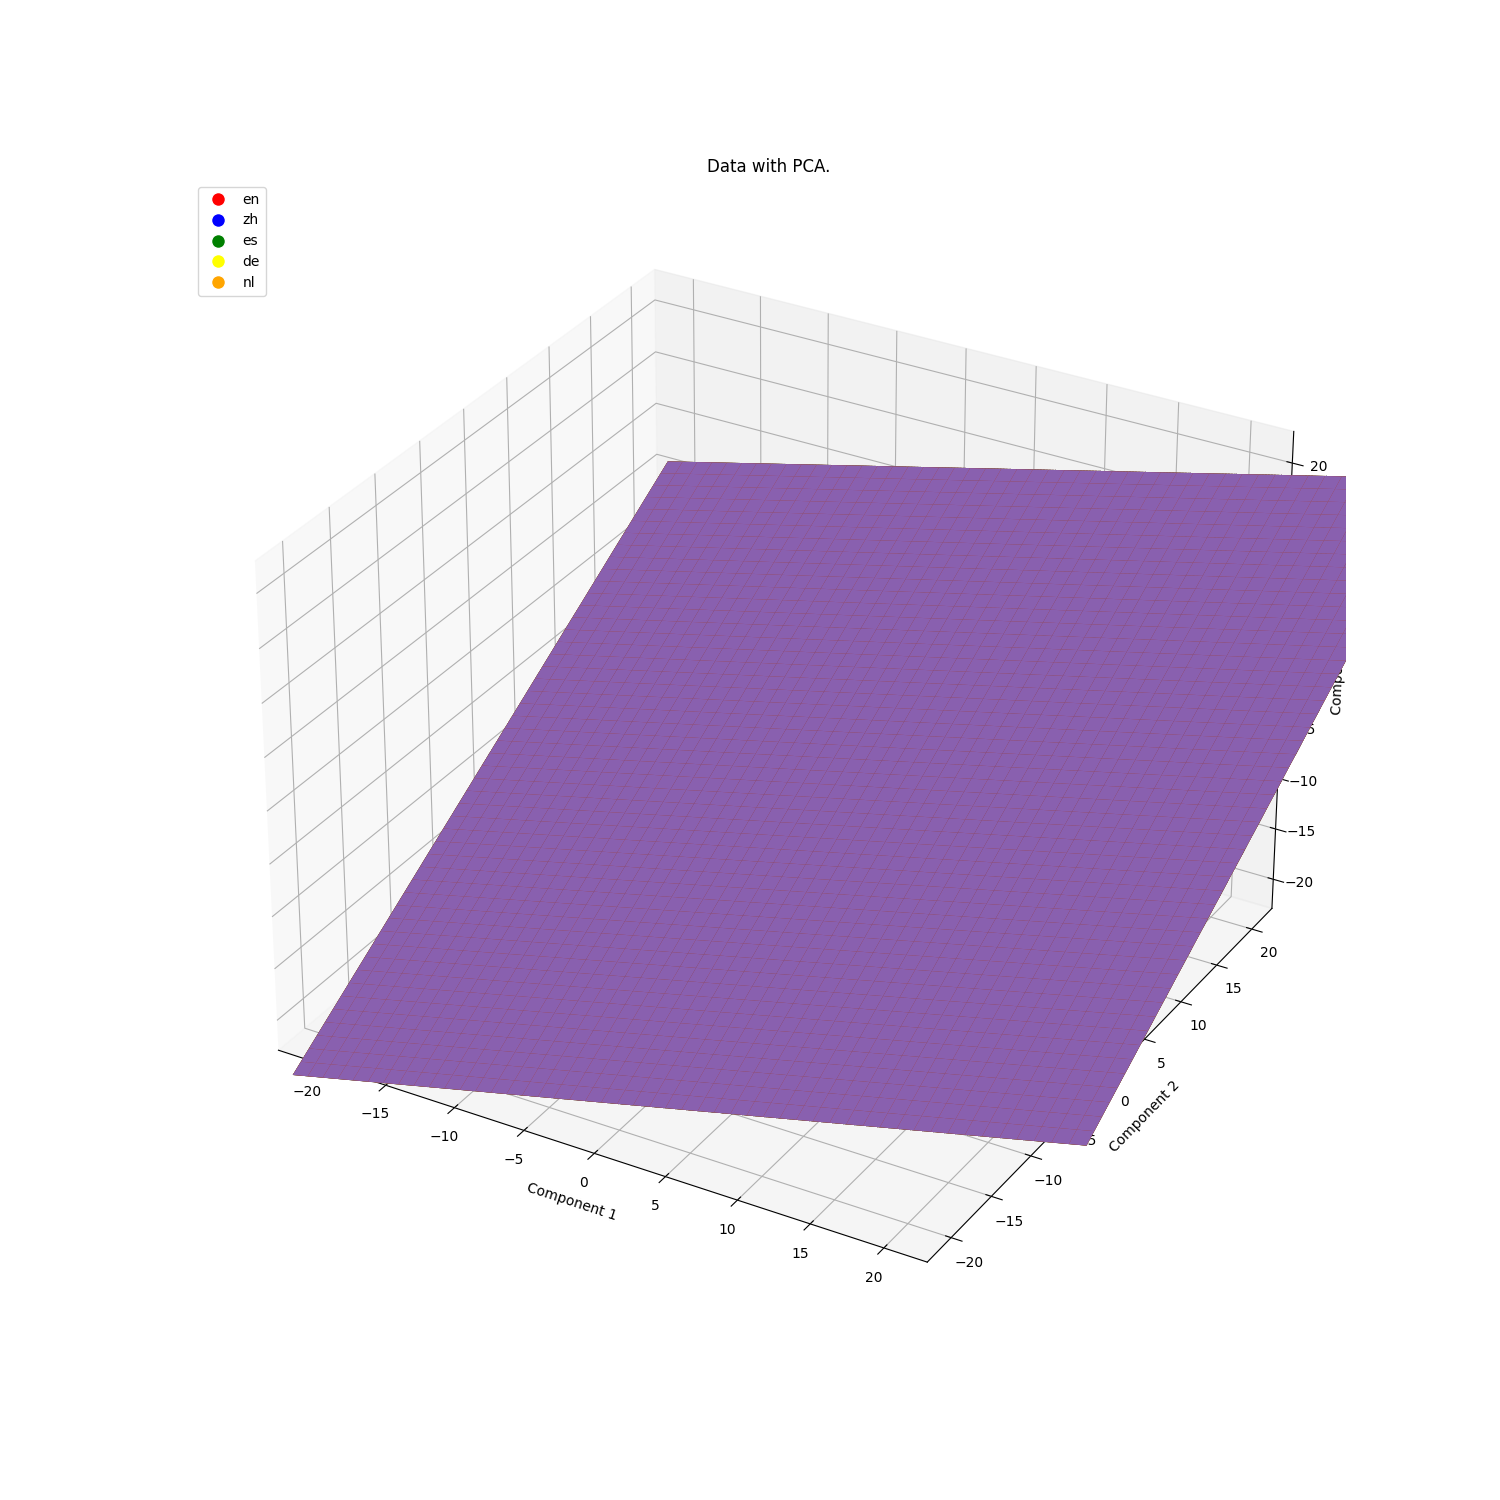

range(0, 10000)
range(46364, 56364)
range(202376, 212376)
range(253577, 263577)
range(305273, 315273)


In [38]:
%matplotlib notebook

plt.rcParams["figure.figsize"] = (15,15)
ax = plt.axes(projection='3d')
ax.grid()

# data size from each lang
size = 10000
alpha = 1

# create a scatter plot of the projection
for lang in TRAIN_LANGS:
    range_indx = range(lang_starting_index[lang], lang_starting_index[lang] + size)
    print(range_indx)
    
    #points
    ax.scatter(x_pca.T[range_indx, 0], x_pca.T[range_indx, 1], x_pca.T[range_indx, 2], color=color_lang_arr[list(range_indx)].tolist(), alpha=alpha)

    
    #boundary    
    boundary_x1_pca = np.linspace([-x1_size, x1_size], 30)
    boundary_x2_pca = np.linspace([-x2_size, x2_size], 30)
    xx, yy = np.meshgrid(boundary_x1_pca, boundary_x2_pca)
    
    
    # IMPORTANT!!!!! put old intercept 
    zz_de = -(clf_de_b + clf_de_w_centered[-1] + np.dot(new_coeffs_de[0], xx) + np.dot(new_coeffs_de[1], yy)) / new_coeffs_de[2] 
    ax.plot_surface(xx, yy, zz_de)
    
    
    #words
#     for i, word in enumerate(words_arr[list(range_indx)].tolist()):
#         ax.text(x_pca.T[range_indx[i], 0], x_pca.T[range_indx[i], 1], x_pca.T[range_indx[i], 2], word)
         

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=l, markerfacecolor=c, markersize=10) 
    for l, c in lang_color.items()
]

# Create the figure
ax.legend(handles=legend_elements, loc='upper left')
ax.set_xlim(-22, 22)
ax.set_ylim(-22, 22)
ax.set_zlim(-22, 22)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.set_title('Data with PCA.')
        
plt.show()